# Additional Work (Kür): Global Diamond Production Analytics

In [2]:
# import packages
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from datetime import datetime
from dateutil import parser
from pandas_profiling import ProfileReport
import warnings
warnings.filterwarnings("ignore")
from plotly.subplots import make_subplots

%matplotlib inline

Data Source:
https://ourworldindata.org/grapher/diamond-production?time=2015

Note: Maps from plotly only show up in **Jupyter Notebook**!    

For use in JupyterLab, install the jupyterlab and ipywidgets packages:  
https://plotly.com/python/getting-started/  and Node.js: https://nodejs.org/en/

## 1. Preparing the data

In [3]:
# load csv data
df = pd.read_csv("diamond-production.csv",delimiter=",") # data about N fertilizer use in kg per hectare
diamonds = pd.read_csv("diamonds.csv")
df.head()

Entity Code  Year  Diamond (BGS (2016))
0  Angola  AGO  1970               2396000
1  Angola  AGO  1971               2413021
2  Angola  AGO  1972               2155057
3  Angola  AGO  1973               2124720
4  Angola  AGO  1974               1959272

In [4]:
# rename columns for better handling
df.rename(columns = {'Entity':'Country', 'Diamond (BGS (2016))': 'prod_val'}, inplace = True)
df.head()

Country Code  Year  prod_val
0  Angola  AGO  1970   2396000
1  Angola  AGO  1971   2413021
2  Angola  AGO  1972   2155057
3  Angola  AGO  1973   2124720
4  Angola  AGO  1974   1959272

Before the analysis, we categorized the carat range of the diamond.csv data set into 5 classes by steps of 0.40


| Class number | value range [carat] | categorical rating |
| :--- | :--- | :--- |
| 1 | < 0.40 | very low |
| 2 | 0.40 - 0.80 | low |
| 3 | 0.80 - 1.20 | medium |
| 4 |  1.20 - 1.60| high |
| 5 | > 1.60 ct | very high |


In [5]:
# Divide the diamond carats by 0.4 to limit the number of carat categories
# Round up to have discrete categories
diamonds["carat_cat"] = np.ceil(diamonds["carat"] / 0.35)

# Merge categories > 5 in 5
diamonds["carat_cat"].where(diamonds["carat_cat"] < 5, 5.0, inplace = True)

In [6]:
# calculate the Class median price per carat category
diamonds.groupby(['carat_cat'])['price'].median()

carat_cat
1.0      676.0
2.0     1362.5
3.0     3888.0
4.0     5996.0
5.0    12052.0
Name: price, dtype: float64

Fetching of percentual distribution of the selected variables from the diamonds.csv data set:

<img src="percent_values.png">

**The the distribution for the variables Carat classes, Color, Cut, Clarity and Price (Class median) of the diamonds.csv dataset is extrapolated on the Global Diamond Production dataset by applying the above shown percentages.**

In [7]:
# applying percentage of carat classes (step: 0.35 carat) to the BGS data
df["carat_1"] = (df['prod_val']*20.52 / 100).round() # 0 - 0.40 ct
df["carat_2"] = (df['prod_val']*29.88 / 100).round() # 0.40 - 0.80 ct
df["carat_3"] = (df['prod_val']*24.85 / 100).round() # 0.80 - 1.20 ct
df["carat_4"] = (df['prod_val']*12.92 / 100).round() # 1.20 - 1.60 ct
df["carat_5"] = (df['prod_val']*11.80 / 100).round() # > 1.60 ct

# color percentages
df["color_G"] = (df['prod_val']*20.93 / 100).round()
df["color_E"] = (df['prod_val']*18.17 / 100).round()
df["color_F"] = (df['prod_val']*17.70 / 100).round()
df["color_H"] = (df['prod_val']*15.38 / 100).round()
df["color_D"] = (df['prod_val']*12.57 / 100).round()
df["color_I"] = (df['prod_val']*10.03 / 100).round()
df["color_J"] = (df['prod_val']*5.19 / 100).round()

# clarity percentages
df["cla_SI1"] = (df['prod_val']*24.24 / 100).round()
df["cla_VS2"] = (df['prod_val']*22.74 / 100).round()
df["cla_SI2"] = (df['prod_val']*17.02 / 100).round()
df["cla_VS1"] = (df['prod_val']*15.16 / 100).round()
df["cla_VVS2"] = (df['prod_val']*9.4 / 100).round()
df["cla_VVS1"] = (df['prod_val']*6.78 / 100).round()
df["cla_IF"] = (df['prod_val']*3.32 / 100).round()
df["cla_I1"] = (df['prod_val']*1.32 / 100).round()

# cut percentages
df["cut_Ideal"] = (df['prod_val']*39.98 / 100).round()
df["cut_Premium"] = (df['prod_val']*25.55 / 100).round()
df["cut_Very_Good"] = (df['prod_val']*22.41 / 100).round()
df["cut_Good"] = (df['prod_val']*9.1 / 100).round()
df["cut_Fair"] = (df['prod_val']*2.96 / 100).round()

# calculate prices for every carat class based on median value
df["carat_1_base_price"] = (676 * df.carat_1).round() #1.0      676.0
df["carat_2_base_price"] = (1362 * df.carat_2).round() #2.0     1362.5
df["carat_3_base_price"] = (3888 * df.carat_3).round() #3.0     3888.0
df["carat_4_base_price"] = (5996 * df.carat_4).round() #4.0     5996.0
df["carat_5_base_price"] = (12052 * df.carat_5).round() #5.0    12052.0

In [8]:
# show the enriched dataset structure:
df.head()

Country Code  Year  prod_val   carat_1   carat_2   carat_3   carat_4  \
0  Angola  AGO  1970   2396000  491659.0  715925.0  595406.0  309563.0   
1  Angola  AGO  1971   2413021  495152.0  721011.0  599636.0  311762.0   
2  Angola  AGO  1972   2155057  442218.0  643931.0  535532.0  278433.0   
3  Angola  AGO  1973   2124720  435993.0  634866.0  527993.0  274514.0   
4  Angola  AGO  1974   1959272  402043.0  585430.0  486879.0  253138.0   

    carat_5   color_G  ...  cut_Ideal  cut_Premium  cut_Very_Good  cut_Good  \
0  282728.0  501483.0  ...   957921.0     612178.0       536944.0  218036.0   
1  284736.0  505045.0  ...   964726.0     616527.0       540758.0  219585.0   
2  254297.0  451053.0  ...   861592.0     550617.0       482948.0  196110.0   
3  250717.0  444704.0  ...   849463.0     542866.0       476150.0  193350.0   
4  231194.0  410076.0  ...   783317.0     500594.0       439073.0  178294.0   

   cut_Fair  carat_1_base_price  carat_2_base_price  carat_3_base_price  \
0   70922.0         332361484.0         975089850.0        2.314939e+09   
1   71425.0         334722752.0         982016982.0        2.331385e+09   
2   63790.0         298939368.0         877034022.0        2.082148e+09   
3   62892.0         294731268.0         864687492.0        2.052837e+09   
4   57994.0         271781068.0         797355660.0        1.892986e+09   

   carat_4_base_price  carat_5_base_price  
0        1.856140e+09        3.407438e+09  
1        1.869325e+09        3.431638e+09  
2        1.669484e+09        3.064787e+09  
3        1.645986e+09        3.021641e+09  
4        1.517815e+09        2.786350e+09  

[5 rows x 34 columns]

## 2. Case Study: Global Diamond Production

In this study, we try to answer the following questions to the customer:      

* Which countries are the biggest producers for diamonds? Are they worth investing in?
* How did the global diamond production for these countries change over time and how are the long term decadal changes between 2005 - 2015? 
* What are the dynamics in diamond production according to the data?
* Which of these countries deliver high quality diamonds that are worth investing in, according to the 4C parameters (Carat, Cut, Clarity and color)? 

### 2.1 EDA plotting

Get a global view of the data:

In [9]:
idx = df.groupby(['Country'])['Year'].transform(max) == df['Year']

locations = df[idx].Code
z = df[idx]['prod_val']
text = df[idx][['Country','Year']]

fig = go.Figure(data=go.Choropleth(
    locations = locations,
    z = z,
    text = text,
    colorscale = 'Greens',
    autocolorscale=False,
    reversescale=False,
#   zmin=geodf['Diamond (BGS (2016))'].min(),
    zmax=df['prod_val'].max(),
    marker_line_color='darkgray',
    marker_line_width=0.5,
#    colorbar_tickprefix = '',
    colorbar_title = 'Carat',
))

fig.update_layout(
    title_text='Global Diamond Production per country (latest year on record)',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    ),
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        text='Source: British Geological Service (2016)',
        showarrow = False
    )]
)

fig.show()

We are showing the same data as time series for the global top 15 producing countries

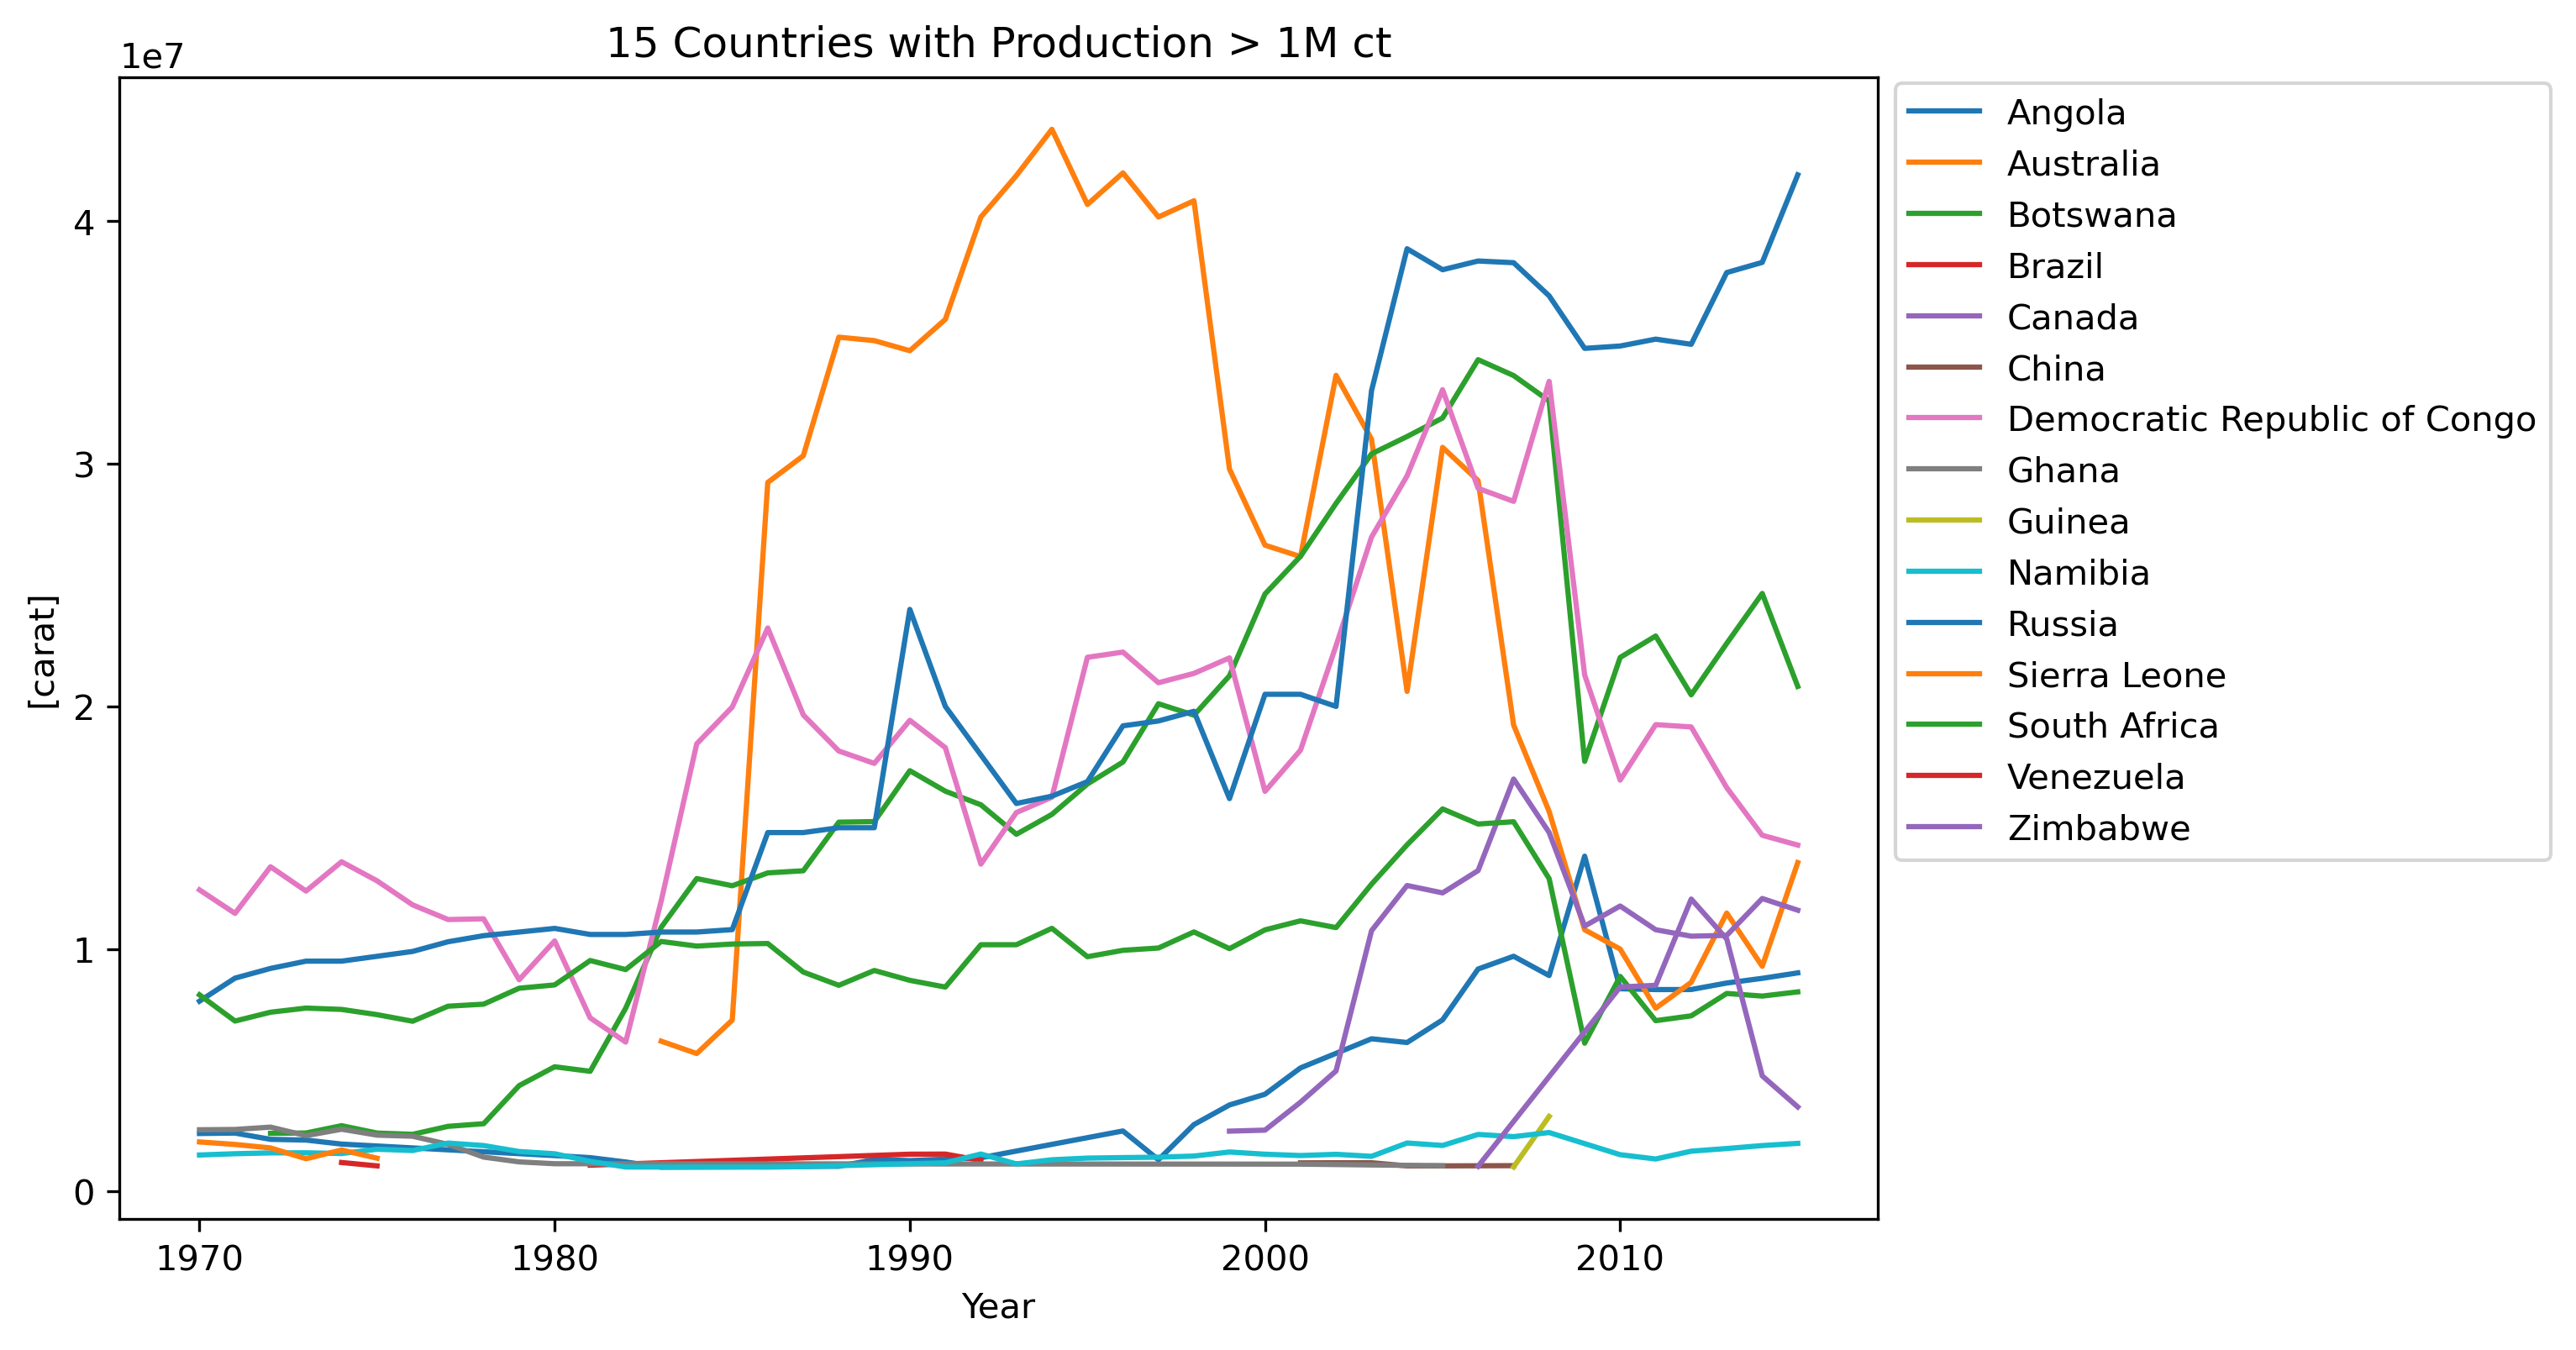

<Figure size 432x288 with 0 Axes>

In [10]:
# show countries with production > 10M carat
palette = sns.color_palette("tab10",15)
#palette = sns.color_palette("Paired",15)
f, axes = plt.subplots(1, 1, figsize=(9,6), dpi=300)
sns.lineplot(data=df.query("prod_val > 1000000"),palette=palette, x="Year", y="prod_val", hue='Country').set(
    title="15 Countries with Production > 1M ct",
    ylabel='[carat]');
plt.legend(bbox_to_anchor=[1, 1.01]);
plt.show()
plt.savefig('lineplot.png', dpi=300)

How can this global dynamics in diamond production be explained?

* Australia: decline around 2000
* Russia: increase around 2000
* the production of Botswana and South Africa remains relatively stable over time; even though they don't have the highest production numbers, they might be identified as reliable suppliers

The Global Diamond Industry Report 2020-01 (Bain & Company) confirms that there are production declines in Canada, Botswana, and Australia in recent years.

### 2.2 Analyzing decadal changes

Standardized workflow:   

1. Subset the data for the selected years 2005 and 2015
2. Merge the dataframes
3. Make calculations and interpret them

In [11]:
# subset of df for 2015
df_2015 = df[(df.Year == 2015) == True]

# subset fot 2005 with countries included in 2015
df_2005 = df[(df.Year == 2005) == True]

In [12]:
# merge on countries that have values for 2015 and 2005
df_merge = pd.merge(df_2015,df_2005, how='inner', on="Country")

# calculate difference between 2015 and 2005 production
df_merge["diff"] = (df_merge.prod_val_x - df_merge.prod_val_y)

In [13]:
# rename columns for better representation
df_merge.rename(columns={'prod_val_x' : 'Production_2015','prod_val_y' : 'Production_2005'},inplace=True)

# show the new structure of the data
df_merge.head()

Country Code_x  Year_x  Production_2015  carat_1_x  carat_2_x  carat_3_x  \
0     Angola    AGO    2015          9016343  1850154.0  2694083.0  2240561.0   
1  Australia    AUS    2015         13560795  2782675.0  4051966.0  3369858.0   
2   Botswana    BWA    2015         20824000  4273085.0  6222211.0  5174764.0   
3     Brazil    BRA    2015            31826     6531.0     9510.0     7909.0   
4   Cameroon    CMR    2015             5000     1026.0     1494.0     1242.0   

   carat_4_x  carat_5_x  color_G_x  ...  cut_Premium_y  cut_Very_Good_y  \
0  1164912.0  1063928.0  1887121.0  ...      1808715.0        1586431.0   
1  1752055.0  1600174.0  2838274.0  ...      7838229.0        6874940.0   
2  2690461.0  2457232.0  4358463.0  ...      8147836.0        7146498.0   
3     4112.0     3755.0     6661.0  ...        53102.0          46576.0   
4      646.0      590.0     1046.0  ...         3066.0           2689.0   

   cut_Good_y  cut_Fair_y  carat_1_base_price_y  carat_2_base_price_y  \
0    644200.0    209542.0          9.819819e+08          2.880958e+09   
1   2791698.0    908069.0          4.255505e+09          1.248489e+10   
2   2901969.0    943937.0          4.423596e+09          1.297804e+10   
3     18913.0      6152.0          2.883005e+07          8.458156e+07   
4      1092.0       355.0          1.664312e+06          4.884132e+06   

   carat_3_base_price_y  carat_4_base_price_y  carat_5_base_price_y      diff  
0          6.839622e+09          5.484074e+09          1.006747e+10   1937222  
1          2.964010e+10          2.376573e+10          4.362829e+10 -17117205  
2          3.081088e+10          2.470447e+10          4.535159e+10 -11065771  
3          2.008035e+08          1.610046e+08          2.955753e+08   -176010  
4          1.159402e+07          9.293800e+06          1.706563e+07     -7000  

[5 rows x 68 columns]

In [14]:
# prepare data for plotting
data   = df_merge[['Country','Production_2015','Production_2005']].query("Production_2015>5000000 & Production_2005>5000000")
tidydf = data.melt(id_vars='Country').rename(columns=str.title)
#tidydf.head()

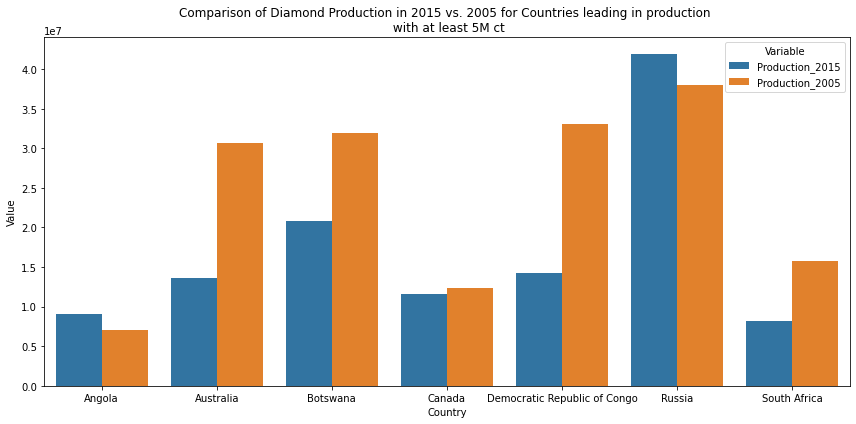

In [15]:
# categorical groupbar plot for prod_val > 5000000
fig, axes = plt.subplots(1,1, figsize=(12,6), tight_layout = True)
g =sns.barplot(x='Country', y='Value',hue='Variable', data=tidydf , ci = None);
g.set(title='Comparison of Diamond Production in 2015 vs. 2005 for Countries leading in production \n with at least 5M ct')
plt.show()

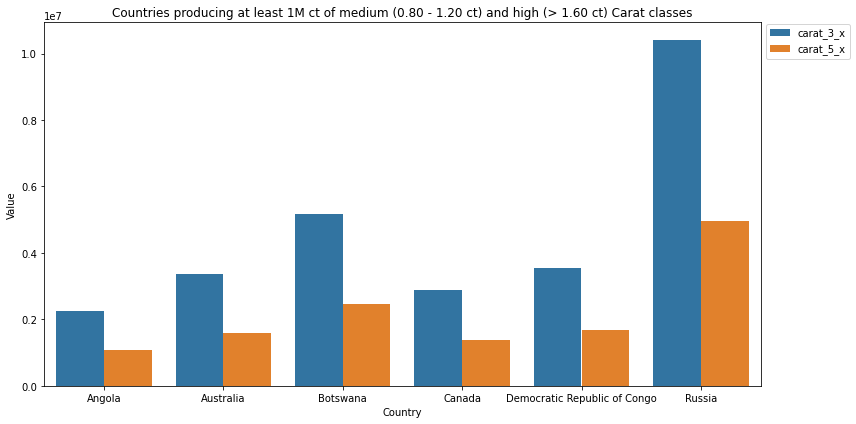

In [16]:
# goal: compare carat classes medium (3) and high (5)

# prepare data for plotting
data   = df_merge[['Country','carat_3_x','carat_5_x']].query("carat_3_x>1000000 & carat_5_x>1000000")
tidydf = data.melt(id_vars='Country').rename(columns=str.title)
#tidydf.head()

#categorical groupbar plot for prod_val > 5000000
fig, axes = plt.subplots(1,1, figsize=(12,6), tight_layout = True)
g =sns.barplot(x='Country', y='Value',hue='Variable', data=tidydf , ci = None);
g.set(title='Countries producing at least 1M ct of medium (0.80 - 1.20 ct) and high (> 1.60 ct) Carat classes');
plt.legend(bbox_to_anchor=[1, 1.01])
plt.show()

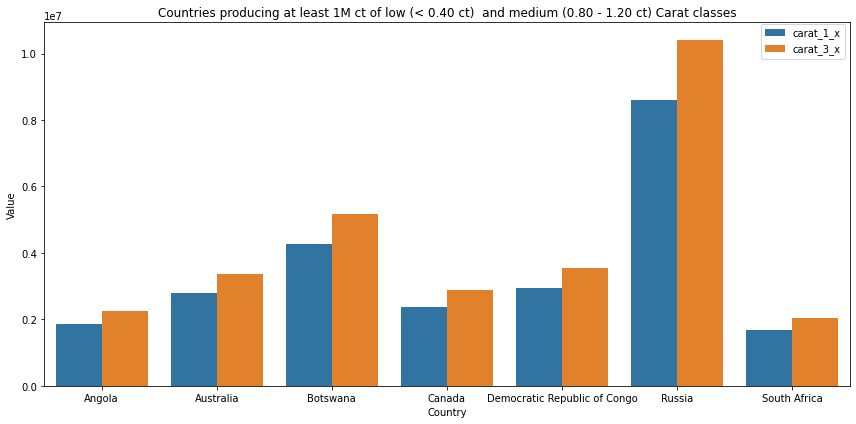

In [17]:
# goal: compare carat classes low (1) and medium (3)

# prepare data for plotting
data   = df_merge[['Country','carat_1_x','carat_3_x']].query("carat_1_x>1000000 & carat_3_x>1000000")
tidydf = data.melt(id_vars='Country').rename(columns=str.title)
#tidydf.head()

#categorical groupbar plot for prod_val > 5000000
fig, axes = plt.subplots(1,1, figsize=(12,6), tight_layout = True)
g =sns.barplot(x='Country', y='Value',hue='Variable', data=tidydf , ci = None);
g.set(title='Countries producing at least 1M ct of low (< 0.40 ct)  and medium (0.80 - 1.20 ct) Carat classes');
plt.legend(bbox_to_anchor=[1, 1.01])
plt.show()

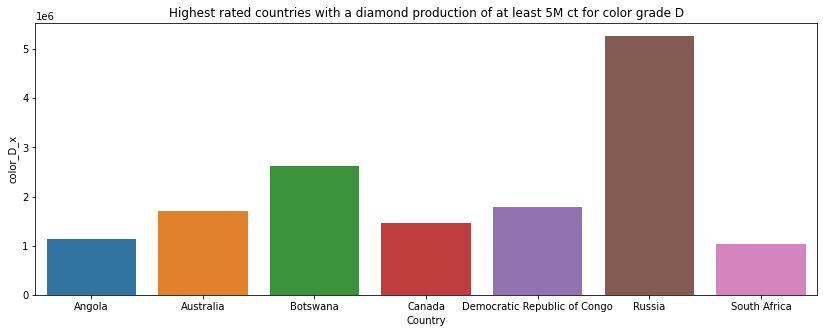

In [18]:
# plot the amount of produced carat that have D grade color
fig, axes = plt.subplots(figsize=(14,5))
a = sns.barplot(x="Country", y="color_D_x",data=df_merge.query("Production_2015>5000000 & Production_2005>5000000"));
a.set(title='Highest rated countries with a diamond production of at least 5M ct for color grade D');

**Conclusion:** 

* All shown countries supply low, medium and high carat diamonds
* Russia is the leading producer of low, medium and high carat rated diamonds
* Botswana is the 2nd biggest producer after Russia according to our  data, followed by Australia, DR Congo, Canada and Angola
* All countries supply much more Medium than Low and High carat diamonds

The identified countries are shown in the map below

In [19]:
# bubble map Global Carat_5 producction for 2015
fig = px.scatter_geo(df_merge.query("Production_2015>5000000"), locations="Code_x", color="Country",
                     hover_name="Country", size="Production_2015",
                     projection="natural earth")
fig.update_layout(height=300,
    title = 'Countries producing more than 5M carat of diamonds')
fig.show()

The above plot also shows that each continent (except South America and Asia) is covered. This might be of interest for local investors what supplier in what region to invest in, also with regard to the regional situation (conflicts, economic situation, working ethics, etc.).

### 2.3 Identification of countries producing high quality diamonds

In [32]:
# display of countries producing the highest amount of Premium cut diamonds
idx1 = df.groupby(['Country'])['cut_Premium'].transform(max) == df['cut_Premium']
data1 = df[idx1].sort_values(by="Year",ascending=False).head(5)

# plot
fig = px.scatter(data1, x="Year", y="prod_val",
             size="cut_Premium", color="Country",
                 hover_name="Country",size_max=60)
fig.show()

### End of Document

----

### Statistical correlation (not included in Kür-Aufgabe)

In [21]:
import statsmodels.api as sm
from statsmodels.api import add_constant

In [22]:
# subset of data for regression
data = df[["prod_val","carat_5"]]
data.head()

prod_val   carat_5
0   2396000  282728.0
1   2413021  284736.0
2   2155057  254297.0
3   2124720  250717.0
4   1959272  231194.0

In [23]:
X = data['carat_5']
y = df['carat_5_base_price']

xc = sm.add_constant(X)
lm = sm.OLS(y.astype(float),xc.astype(float)).fit()

#print(lm.summary())

regression equation:   
price = 1.205e+04 * carat_5 - 1.404e-06   

<Figure size 432x288 with 0 Axes>

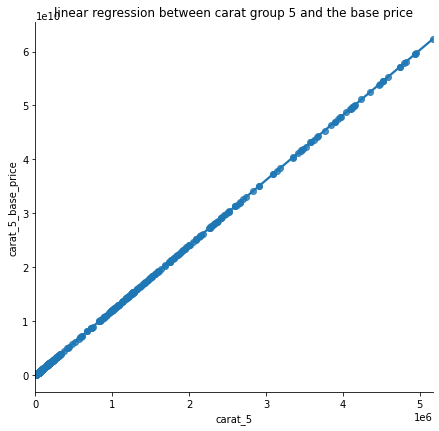

In [24]:
# plotting the regression results
plt.figure();
sns.lmplot(data=df, y='carat_5_base_price', x='carat_5', height=6);
x_line = np.linspace(0, 10, 1)
y_line = lm.params.carat_5 * x_line + lm.params.const
sns.lineplot(x = x_line, y = y_line, color = 'red', linewidth=5);
#plt.xlim(0, 2);
#plt.ylim(0, 1200);
plt.title("linear regression between carat group 5 and the base price");

In [25]:
# select the latest recorded year of every country (Entity)
#idx = df.groupby(['Country'])['Year'].transform(max) == df['Year']
#df[idx].head()

In [26]:
idx = df.groupby(['Country'])['carat_5'].transform(max) == df['carat_5']
df[idx].sort_values(by="carat_5",ascending=False).head(20)

Country Code  Year  prod_val    carat_1     carat_2  \
62                      Australia  AUS  1994  43789000  8985503.0  13084153.0   
779                        Russia  RUS  2015  41912390  8600422.0  12523422.0   
120                      Botswana  BWA  2006  34293401  7037006.0  10246868.0   
377  Democratic Republic of Congo  COD  2008  33401928  6854076.0   9980496.0   
204                        Canada  CAN  2007  17007850  3490011.0   5081946.0   
861                  South Africa  ZAF  2005  15775720  3237178.0   4713785.0   
39                         Angola  AGO  2009  13827609  2837425.0   4131690.0   
996                      Zimbabwe  ZWE  2012  12060163  2474745.0   3603577.0   
486                        Guinea  GIN  2008   3098490   635810.0    925829.0   
404                         Ghana  GHA  1972   2658717   545569.0    794425.0   
726                       Namibia  NAM  2008   2435195   499702.0    727636.0   
780                  Sierra Leone  SLE  1970   2048264   420304.0    612021.0   
151                        Brazil  BRA  1991   1546800   317403.0    462184.0   
935                     Venezuela  VEN  1974   1199973   246234.0    358552.0   
278                         China  CHN  2002   1190000   244188.0    355572.0   
279                         China  CHN  2003   1190000   244188.0    355572.0   
873                      Tanzania  TZA  1971    837190   171791.0    250152.0   
244      Central African Republic  CAF  2001    550000   112860.0    164340.0   
644                       Lesotho  LSO  2012    478926    98276.0    143103.0   
528                        Guyana  GUY  2004    454940    93354.0    135936.0   

        carat_3    carat_4    carat_5    color_G  ...   cut_Ideal  \
62   10881566.0  5657539.0  5167102.0  9165038.0  ...  17506842.0   
779  10415229.0  5415081.0  4945662.0  8772263.0  ...  16756574.0   
120   8521910.0  4430707.0  4046621.0  7177609.0  ...  13710502.0   
377   8300379.0  4315529.0  3941428.0  6991024.0  ...  13354091.0   
204   4226451.0  2197414.0  2006926.0  3559743.0  ...   6799738.0   
861   3920266.0  2038223.0  1861535.0  3301858.0  ...   6307133.0   
39    3436161.0  1786527.0  1631658.0  2894119.0  ...   5528278.0   
996   2996951.0  1558173.0  1423099.0  2524192.0  ...   4821653.0   
486    769975.0   400325.0   365622.0   648514.0  ...   1238776.0   
404    660691.0   343506.0   313729.0   556469.0  ...   1062955.0   
726    605146.0   314627.0   287353.0   509686.0  ...    973591.0   
780    508994.0   264636.0   241695.0   428702.0  ...    818896.0   
151    384380.0   199847.0   182522.0   323745.0  ...    618411.0   
935    298193.0   155037.0   141597.0   251154.0  ...    479749.0   
278    295715.0   153748.0   140420.0   249067.0  ...    475762.0   
279    295715.0   153748.0   140420.0   249067.0  ...    475762.0   
873    208042.0   108165.0    98788.0   175224.0  ...    334709.0   
244    136675.0    71060.0    64900.0   115115.0  ...    219890.0   
644    119013.0    61877.0    56513.0   100239.0  ...    191475.0   
528    113053.0    58778.0    53683.0    95219.0  ...    181885.0   

     cut_Premium  cut_Very_Good   cut_Good   cut_Fair  carat_1_base_price  \
62    11188090.0      9813115.0  3984799.0  1296154.0        6.074200e+09   
779   10708616.0      9392567.0  3814027.0  1240607.0        5.813885e+09   
120    8761964.0      7685151.0  3120699.0  1015085.0        4.757016e+09   
377    8534193.0      7485372.0  3039575.0   988697.0        4.633355e+09   
204    4345506.0      3811459.0  1547714.0   503432.0        2.359247e+09   
861    4030696.0      3535339.0  1435591.0   466961.0        2.188332e+09   
39     3532954.0      3098767.0  1258312.0   409297.0        1.918099e+09   
996    3081372.0      2702683.0  1097475.0   356981.0        1.672928e+09   
486     791664.0       694372.0   281963.0    91715.0        4.298076e+08   
404     679302.0       595818.0   241943.0    78698.0        3.688046e+08   
726     622192.0       5457

In [27]:
idx = df.groupby(['Country'])['carat_5'].transform(max) == df['carat_5']
df[idx].sort_values(by="Year",ascending=False).head(10)

Country Code  Year  prod_val    carat_1     carat_2  \
779                        Russia  RUS  2015  41912390  8600422.0  12523422.0   
996                      Zimbabwe  ZWE  2012  12060163  2474745.0   3603577.0   
644                       Lesotho  LSO  2012    478926    98276.0    143103.0   
295                         Congo  COG  2010    381242    78231.0    113915.0   
39                         Angola  AGO  2009  13827609  2837425.0   4131690.0   
486                        Guinea  GIN  2008   3098490   635810.0    925829.0   
183                      Cameroon  CMR  2008     12000     2462.0      3586.0   
726                       Namibia  NAM  2008   2435195   499702.0    727636.0   
377  Democratic Republic of Congo  COD  2008  33401928  6854076.0   9980496.0   
182                      Cameroon  CMR  2007     12000     2462.0      3586.0   

        carat_3    carat_4    carat_5    color_G  ...   cut_Ideal  \
779  10415229.0  5415081.0  4945662.0  8772263.0  ...  16756574.0   
996   2996951.0  1558173.0  1423099.0  2524192.0  ...   4821653.0   
644    119013.0    61877.0    56513.0   100239.0  ...    191475.0   
295     94739.0    49256.0    44987.0    79794.0  ...    152421.0   
39    3436161.0  1786527.0  1631658.0  2894119.0  ...   5528278.0   
486    769975.0   400325.0   365622.0   648514.0  ...   1238776.0   
183      2982.0     1550.0     1416.0     2512.0  ...      4798.0   
726    605146.0   314627.0   287353.0   509686.0  ...    973591.0   
377   8300379.0  4315529.0  3941428.0  6991024.0  ...  13354091.0   
182      2982.0     1550.0     1416.0     2512.0  ...      4798.0   

     cut_Premium  cut_Very_Good   cut_Good   cut_Fair  carat_1_base_price  \
779   10708616.0      9392567.0  3814027.0  1240607.0        5.813885e+09   
996    3081372.0      2702683.0  1097475.0   356981.0        1.672928e+09   
644     122366.0       107327.0    43582.0    14176.0        6.643458e+07   
295      97407.0        85436.0    34693.0    11285.0        5.288416e+07   
39     3532954.0      3098767.0  1258312.0   409297.0        1.918099e+09   
486     791664.0       694372.0   281963.0    91715.0        4.298076e+08   
183       3066.0         2689.0     1092.0      355.0        1.664312e+06   
726     622192.0       545727.0   221603.0    72082.0        3.377986e+08   
377    8534193.0      7485372.0  3039575.0   988697.0        4.633355e+09   
182       3066.0         2689.0     1092.0      355.0        1.664312e+06   

     carat_2_base_price  carat_3_base_price  carat_4_base_price  \
779        1.705690e+10        4.049441e+10        3.246883e+10   
996        4.908072e+09        1.165215e+10        9.342805e+09   
644        1.949063e+08        4.627225e+08        3.710145e+08   
295        1.551522e+08        3.683452e+08        2.953390e+08   
39         5.627362e+09        1.335979e+10        1.071202e+10   
486        1.260979e+09        2.993663e+09        2.400349e+09   
183        4.884132e+06        1.159402e+07        9.293800e+06   
726        9.910402e+08        2.352808e+09        1.886503e+09   
377        1.359344e+10        3.227187e+10        2.587591e+10   
182        4.884132e+06        1.159402e+07        9.293800e+06   

     carat_5_base_price  
779        5.960512e+10  
996        1.715119e+10  
644        6.810947e+08  
295        5.421833e+08  
39         1.966474e+10  
486        4.406476e+09  
183        1.706563e+07  
726        3.463178e+09  
377        4.750209e+10  
182        1.706563e+07  

[10 rows x 34 columns]

In [28]:
# categorical bubble chart
data = df[idx].sort_values(by="Year",ascending=False).head(5)
fig = px.scatter(data, x="Year", y="prod_val",
             size="carat_5", color="Country",
                 hover_name="Country", size_max=60)
fig.show()

In [29]:
idx3 = df.groupby(['Country'])['carat_5'].transform(max) == df['carat_5']
data3 = df[idx3].sort_values(by="carat_5",ascending=False).head(5)
#df = px.data.gapminder()
fig = px.scatter(data3.query("Year>2000"), x="Year", y="prod_val",
             size="carat_5", color="Country",
                 hover_name="Country", log_x=True, size_max=60)
fig.show()

In [30]:
idx4 = df.groupby(['Country'])['cut_Premium'].transform(max) == df['cut_Premium']
data4 = df[idx4].sort_values(by="cut_Premium",ascending=False).head(5)
#df = px.data.gapminder()
fig = px.scatter(data4, x="Year", y="prod_val",
             size="cut_Premium", color="Country",
                 hover_name="Country", log_x=True, size_max=60)
fig.show()
#df.query("Year > 2000")

In [31]:
idx5 = df.groupby(['Country'])['prod_val'].transform(min) == df['prod_val']
data5 = df[idx5].sort_values(by="prod_val",ascending=False).head(20)

idx6 = df.groupby(['Country'])['prod_val'].transform(max) == df['prod_val']
data6 = df[idx6].sort_values(by="prod_val",ascending=False).head(20)